In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

import numpy as np
import shap
from shap.plots import waterfall

In [2]:
df = pd.read_csv('C:\\Users\\DMC CONET\\Documents\\python\\project1\\data\\종합데이터(수정).csv', index_col = 0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4464 entries, 0 to 4463
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   기준년월      4464 non-null   int64  
 1   대표자성별명    4464 non-null   object 
 2   대표자연령대명   4464 non-null   object 
 3   설립년도      4464 non-null   int64  
 4   사업지역명     4464 non-null   object 
 5   사업업종코드    4464 non-null   int64  
 6   사업업종명     4464 non-null   object 
 7   종업원수구분명   4464 non-null   object 
 8   재무기준년도    4464 non-null   int64  
 9   자본금액      4464 non-null   int64  
 10  매출금액      4464 non-null   int64  
 11  영업이익      4464 non-null   int64  
 12  당기순이익     4464 non-null   int64  
 13  자산총합계금액   4464 non-null   int64  
 14  부채총합계금액   4464 non-null   int64  
 15  보증잔액      4464 non-null   int64  
 16  운전자금대출여부  4464 non-null   object 
 17  시설자금대출여부  4464 non-null   object 
 18  예금평잔      4464 non-null   int64  
 19  대출평잔      4464 non-null   int64  
 20  신용평가등급명   4464 non-null   obje

In [4]:
df.columns

Index(['기준년월', '대표자성별명', '대표자연령대명', '설립년도', '사업지역명', '사업업종코드', '사업업종명',
       '종업원수구분명', '재무기준년도', '자본금액', '매출금액', '영업이익', '당기순이익', '자산총합계금액',
       '부채총합계금액', '보증잔액', '운전자금대출여부', '시설자금대출여부', '예금평잔', '대출평잔', '신용평가등급명',
       '신용점수', '신용등급'],
      dtype='object')

In [5]:
X = df[['종업원수구분명', '자본금액', '매출금액', '영업이익', '당기순이익', '자산총합계금액',
       '부채총합계금액', '보증잔액', '운전자금대출여부', '시설자금대출여부', '예금평잔', '대출평잔']]
y = df['신용등급']

In [6]:
y1 = y.replace({'E' : 0, 'D' : 0, 'C' : 0, 'B' : 1, 'A' : 1})
y2 = y.replace({'E' : 0, 'D' : 0, 'C' : 0, 'B' : 0, 'A' : 1})

In [7]:
X['종업원수구분명'].replace({'0명' : 0, '1명 이상 5명 미만' : 1, '5명 이상 10명 미만' : 2, '10명 이상 30명 미만' : 3}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
num_list = X.describe().columns.tolist()
cat_list = X.describe(include = 'object').columns.tolist()

In [9]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, random_state = 42)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train1[num_list])

X_train1[num_list] = scaler.transform(X_train1[num_list])
X_test1[num_list] = scaler.transform(X_test1[num_list])

In [11]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)

X_train1_ohe = pd.DataFrame(ohe.fit_transform(X_train1[cat_list]), columns = ohe.get_feature_names())
X_test1_ohe = pd.DataFrame(ohe.fit_transform(X_test1[cat_list]), columns = ohe.get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [12]:
X_train1_fin = pd.concat([X_train1[num_list].reset_index(drop = True), X_train1_ohe], axis = 1)
X_test1_fin = pd.concat([X_test1[num_list].reset_index(drop = True), X_test1_ohe], axis = 1)

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model1 = XGBClassifier()
model1.fit(X_train1_fin, y_train1)

hyper_parameters = {
    'max_depth' : range(5, 11),
    'learning_rate' : [0.1, 0.2, 0.3],
    'gamma' : [0, 1, 3, 5]
}

grid_model = GridSearchCV(estimator = model1, param_grid = hyper_parameters, cv = 3, n_jobs = -1, scoring = 'f1')
grid_model.fit(X_train1_fin, y_train1)

best_model1 = grid_model.best_estimator_

y_train_pred1 = best_model1.predict(X_train1_fin)
y_test_pred1 = best_model1.predict(X_test1_fin)

print(classification_report(y_train1, y_train_pred1))
print(classification_report(y_test1, y_test_pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2526
           1       1.00      1.00      1.00       822

    accuracy                           1.00      3348
   macro avg       1.00      1.00      1.00      3348
weighted avg       1.00      1.00      1.00      3348

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       822
           1       1.00      1.00      1.00       294

    accuracy                           1.00      1116
   macro avg       1.00      1.00      1.00      1116
weighted avg       1.00      1.00      1.00      1116



In [14]:
explainer1 = shap.Explainer(best_model1, X_test1_fin)
shap_values1 = explainer1(X_test1_fin)

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


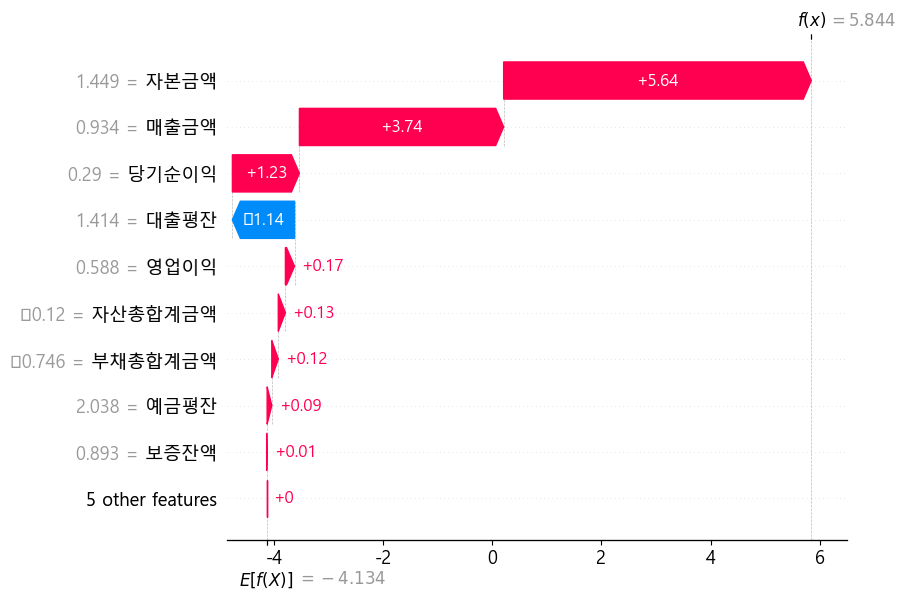

In [15]:
shap.plots.waterfall(shap_values1[1])

In [16]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, random_state = 42)

In [17]:
scaler = StandardScaler()
scaler.fit(X_train2[num_list])

X_train2[num_list] = scaler.transform(X_train2[num_list])
X_test2[num_list] = scaler.transform(X_test2[num_list])

In [18]:
ohe = OneHotEncoder(sparse = False)

X_train2_ohe = pd.DataFrame(ohe.fit_transform(X_train2[cat_list]), columns = ohe.get_feature_names())
X_test2_ohe = pd.DataFrame(ohe.fit_transform(X_test2[cat_list]), columns = ohe.get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [19]:
X_train2_fin = pd.concat([X_train2[num_list].reset_index(drop = True), X_train2_ohe], axis = 1)
X_test2_fin = pd.concat([X_test2[num_list].reset_index(drop = True), X_test2_ohe], axis = 1)

In [20]:
model2 = XGBClassifier()
model2.fit(X_train2_fin, y_train2)

hyper_parameters = {
    'max_depth' : range(5, 11),
    'learning_rate' : [0.1, 0.2, 0.3],
    'gamma' : [0, 1, 3, 5]
}

grid_model = GridSearchCV(estimator = model2, param_grid = hyper_parameters, cv = 3, n_jobs = -1, scoring = 'f1')
grid_model.fit(X_train2_fin, y_train2)

best_model2 = grid_model.best_estimator_

y_train_pred2 = best_model2.predict(X_train2_fin)
y_test_pred2 = best_model2.predict(X_test2_fin)

print(classification_report(y_train2, y_train_pred2))
print(classification_report(y_test2, y_test_pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3120
           1       1.00      1.00      1.00       228

    accuracy                           1.00      3348
   macro avg       1.00      1.00      1.00      3348
weighted avg       1.00      1.00      1.00      3348

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      0.94      0.97        81

    accuracy                           1.00      1116
   macro avg       1.00      0.97      0.98      1116
weighted avg       1.00      1.00      1.00      1116



In [21]:
explainer2 = shap.Explainer(best_model2, X_test2_fin)
shap_values2 = explainer1(X_test2_fin)

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


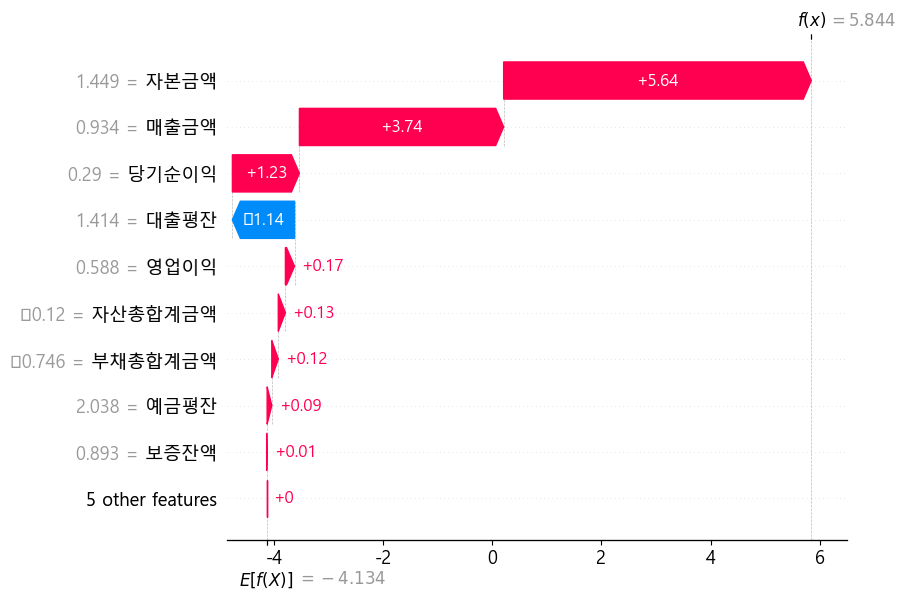

In [22]:
shap.plots.waterfall(shap_values2[1])

In [23]:
X = df[['종업원수구분명', '자본금액', '매출금액', '영업이익', '당기순이익', '자산총합계금액',
       '부채총합계금액', '보증잔액', '운전자금대출여부', '시설자금대출여부', '예금평잔', '대출평잔']]
y = df['신용평가등급명']

In [24]:
X['종업원수구분명'].replace({'0명' : 0, '1명 이상 5명 미만' : 1, '5명 이상 10명 미만' : 2, '10명 이상 30명 미만' : 3}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
y.replace({'보통이하' : 0, '양호' : 0, '우수' : 1}, inplace = True)

In [26]:
y.value_counts()

0    3609
1     855
Name: 신용평가등급명, dtype: int64

In [27]:
num_list = X.describe().columns.tolist()
cat_list = X.describe(include = 'object').columns.tolist()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [29]:
scaler = StandardScaler()
scaler.fit(X_train[num_list])

X_train[num_list] = scaler.transform(X_train[num_list])
X_test[num_list] = scaler.transform(X_test[num_list])

In [30]:
ohe = OneHotEncoder(sparse = False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[cat_list]), columns = ohe.get_feature_names())
X_test_ohe = pd.DataFrame(ohe.fit_transform(X_test[cat_list]), columns = ohe.get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [31]:
X_train = pd.concat([X_train[num_list].reset_index(drop = True), X_train_ohe], axis = 1)
X_test = pd.concat([X_test[num_list].reset_index(drop = True), X_test_ohe], axis = 1)

In [32]:
model = XGBClassifier()
model.fit(X_train, y_train)

hyper_parameters = {
    'max_depth' : range(5, 11),
    'learning_rate' : [0.1, 0.2, 0.3],
    'gamma' : [0, 1, 3, 5]
}

grid_model = GridSearchCV(estimator = model, param_grid = hyper_parameters, cv = 3, n_jobs = -1, scoring = 'f1')
grid_model.fit(X_train, y_train)

best_model = grid_model.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2707
           1       0.91      0.42      0.58       641

    accuracy                           0.88      3348
   macro avg       0.89      0.71      0.75      3348
weighted avg       0.88      0.88      0.86      3348

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       902
           1       0.87      0.43      0.58       214

    accuracy                           0.88      1116
   macro avg       0.87      0.71      0.75      1116
weighted avg       0.88      0.88      0.86      1116



Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


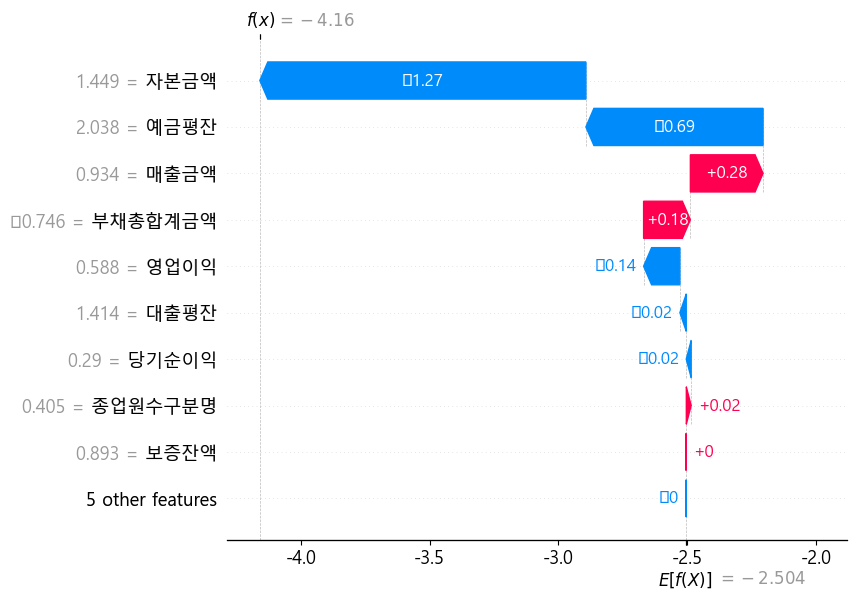

In [33]:
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[1])